<a href="https://colab.research.google.com/github/jems2019/CMPE-297-98-Project/blob/master/CNN_using_TFX_Serving_with_Resnet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---





---



In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.15.0


##TFX Serving

In [0]:
#load model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Emerging Technologies Project - AI based trading platform/resnet.h5') 

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 23,605,843
Trainable params: 41,043
Non-trainable params: 23,564,800
_______________________________________

In [0]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 2068
-rw-r--r-- 1 root root 2109552 Dec  4 21:10 saved_model.pb
drwxr-xr-x 2 root root    4096 Dec  4 21:10 variables


In [0]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: resnet50v2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: dense_1/Softmax:0
  Method name is: tensorflow/serving/predict


In [0]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   5074      0 --:--:-- --:--:-- --:--:--  5074
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ge

In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 140 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-servin

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=stock_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [0]:
!tail server.log

2019-12-04 21:10:29.259852: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-12-04 21:10:29.281114: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-12-04 21:10:29.362299: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-12-04 21:10:29.657739: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 419671 microseconds.
2019-12-04 21:10:29.669072: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2019-12-04 21:10:29.669187: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: stock_model version: 1}
2019-12-04 21:10:29.670910: I tensorflow_serving/model

Using TensorFlow backend.


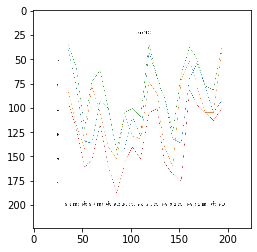

In [0]:
from keras.preprocessing import image
img1 = image.load_img("/content/drive/My Drive/Emerging Technologies Project - AI based trading platform/test_stock.jpeg",target_size=(224,224))
img1 = np.asarray(img1)
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)


In [0]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

'{"signature_name": "serving_default", "instances": [[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255,

In [0]:
class_dictionary = ['buy','hold','sell']

In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/stock_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
output = predictions[0]

[1.0, 3.95462405e-30, 1.85935e-24]


'buy'

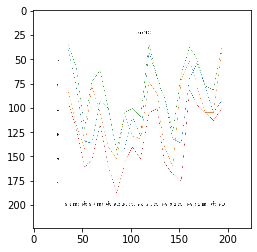

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/Emerging Technologies Project - AI based trading platform/test_stock.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
class_dictionary[np.argmax(output)]